mount google drive

In [3]:
from google.colab import drive

# unmount first if already mounted
drive.flush_and_unmount()

# mount the drive again
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


necessary imports

In [1]:
!pip install mediapipe
!pip uninstall -y numpy
!pip install numpy==2.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 106.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 100.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.0.2 which is incompatible.


In [48]:
import os
import shutil
import re
import random
import numpy as np
import cv2
import sys
import mediapipe as mp
import imageio
import h5py
import logging
import multiprocessing

from PIL import Image, ImageEnhance, ImageSequence
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import LossScaleOptimizer, set_global_policy
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight

import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix


data folders

In [10]:
input_folder = "/content/drive/MyDrive/Colab Notebooks/Data/chosen_signs/"
output_folder = "/content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/"

# create output directory if it does not exist
os.makedirs(output_folder, exist_ok = True)

# Augment Data

augment functions

In [6]:
def random_rotate(image):
  # slightly rotate the image randomly within +- 10 degrees
  angle = random.uniform(-10, 10)
  return image.rotate(angle, resample = Image.BICUBIC, fillcolor = (0, 0, 0, 0))

def random_brightness(image):
  # adjust brightness - slightly darken or brighten
  enhancer = ImageEnhance.Brightness(image)
  factor = random.uniform(0.7, 1.3)
  return enhancer.enhance(factor)

def random_contrast(image):
  # adjust contrast slightly
  enhancer = ImageEnhance.Contrast(image)
  factor = random.uniform(0.7, 1.3)
  return enhancer.enhance(factor)

def random_translate(image):
  # translate image slightly - shift max 10 pixels along the x and/or y axis
  max_shift = 10
  dx, dy = random.randint(-max_shift, max_shift), random.randint(-max_shift, max_shift)
  return image.transform(image.size, Image.AFFINE, (1, 0, dx, 0, 1, dy))

def random_sharpness(image):
  # adjust sharpness - make the image more or less sharp
  enhancer = ImageEnhance.Sharpness(image)
  factor = random.uniform(0.7, 1.3)
  return enhancer.enhance(factor)

def random_saturation(image):
  # adjust saturation - make the colors more or less vivid
  enhancer = ImageEnhance.Color(image)
  factor = random.uniform(0.7, 1.3)
  return enhancer.enhance(factor)

def random_noise(image):
  # add more noticeable random noise to the image - simulates poor lighting or noisy environments
  np_image = np.array(image)
  noise = np.random.normal(0, 10, np_image.shape)
  noisy_image = np_image + noise
  noisy_image = np.clip(noisy_image, 0, 255)
  return Image.fromarray(noisy_image.astype(np.uint8))

process data and apply augmentation functions

In [8]:
def extract_uppercase_name(filename):
  # extracts only the uppercase words at the front of the file - name of the gestures
  base_name = os.path.basename(filename).split('.')[0]  # get only the name without extenstion
  match = re.match(r'^([A-Z_]+)', base_name) # get uppercase words at the start
  return match.group(1) if match else base_name  # return words or not return whole name

# apply agumentation to gif and save - save original + 49 different variations of the data for training
def augment_gif(input_path, output_path, num_variations = 49, frame_skip = 5):
  gif = Image.open(input_path)
  frames = [frame.convert("RGBA").copy() for frame in ImageSequence.Iterator(gif)]  # extract frames and ensure in RGBA format (prevent glitches or distortions)

  class_filename = extract_uppercase_name(input_path)

  # save the original GIF
  original_save_path = os.path.join(output_path, f"{class_filename}_original.gif")
  frames[0].save(original_save_path, save_all = True, append_images = frames[1:], duration = gif.info['duration'], loop = 0)

  # generate augmented GIFs
  for i in range(num_variations):
      augmented_frames = []

      for idx, frame in enumerate(frames):
        frame = frame.convert("RGB")  # Convert to RGB format

        # apply augmentation only every 'frame_skip' frames
        if idx % frame_skip == 0:
          frame = random_rotate(frame)
          frame = random_brightness(frame)
          frame = random_contrast(frame)
          frame = random_translate(frame)
          frame = random_sharpness(frame)
          frame = random_saturation(frame)
          frame = random_noise(frame)

        augmented_frames.append(frame)

      # save augmented GIF
      save_path = os.path.join(output_path, f"{class_filename}_aug_{i}.gif")
      augmented_frames[0].save(save_path, save_all = True, append_images = augmented_frames[1:], duration = gif.info['duration'], loop = 0)

# function to process multiple GIFs in parallel
def process_gif(args):
    input_path, output_path, num_variations = args
    augment_gif(input_path, output_path, num_variations)

# function to process and update the tqdm progress bar
def process_gif_and_update_bar(input_path, output_path, num_variations, pbar):
    augment_gif(input_path, output_path, num_variations)
    pbar.update(1)  # update progress bar after processing each file

# function to augment gifs using threadpoolexecutor for parallel processing with tqdm
def augment_gifs_in_parallel(gif_files, output_path, num_variations = 29, num_workers = 4):
    with tqdm(total = len(gif_files), desc = "Processing GIFs", unit = "file") as pbar:
        # Use threadpoolexecutor instead of multiprocessing Pool
        with ThreadPoolExecutor(max_workers = num_workers) as executor:
            futures = []
            for input_path, file in gif_files:
                futures.append(executor.submit(process_gif_and_update_bar, input_path, output_path, num_variations, pbar))

            # wait for all futures to complete
            for future in as_completed(futures):
                future.result()  # get the result to handle exceptions if any

process all the gifs in the data folder

In [11]:
# get all gif files from input folder
gif_files = [(os.path.join(input_folder, file), file) for file in os.listdir(input_folder) if file.endswith(".gif")]

# run the augmentation process in parallel with tqdm progress bar
augment_gifs_in_parallel(gif_files, output_folder, num_variations = 49, num_workers = 4)

print("Augmentation completed! Augmented GIFs saved in:", output_folder)

Processing GIFs: 100%|██████████| 20/20 [43:50<00:00, 131.54s/file]

Augmentation completed! Augmented GIFs saved in: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/


In [12]:
# get the total number of gifs from the augmented dataset (total number of data)
augmented_gifs = [file for file in os.listdir(output_folder) if file.endswith(".gif")]

print("\nTotal number of GIFs in the dataset:", len(augmented_gifs))


Total number of GIFs in the dataset: 1000


# Preprocess Data for Model

In [19]:
# initialize MediaPipe solutions
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands

# initialize MediaPipe models
pose_model = mp_pose.Pose(static_image_mode = False, model_complexity = 2, min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
hand_model = mp_hands.Hands(static_image_mode = False, min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

class SGSL_Dataset(keras.utils.Sequence):
    def __init__(self, folder, batch_size = 32, max_frames = 50, preprocess_file = None):
        self.folder = folder
        self.batch_size = batch_size
        self.max_frames = max_frames
        self.preprocess_file = preprocess_file

        # gather all the GIF files from the folder
        self.gif_files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith(".gif")]

        # extract labels from the file names and store them
        self.labels = self._extract_labels()

        # create sorted list of unique labels
        self.unique_labels = sorted(set(self.labels.values()))

        # maps each unique label to an integer index
        self.label_to_index = {label: i for i, label in enumerate(self.unique_labels)}

        # total number of unique labels (classes)
        self.num_classes = len(self.unique_labels)

        # if preprocess_file is provided, load the preprocessed data
        if self.preprocess_file:
            self.preprocessed_data = self.load_preprocessed_data()
        else:
            self.preprocessed_data = None  # no preprocessed data loaded

    def _extract_labels(self):
        # extract capitalized words from the GIF files names as the label
        labels = {}
        for file in self.gif_files:
            filename = os.path.basename(file).split('.')[0]
            # split the filename by underscores and get the capitalized words
            words = filename.split('_')
            # filter only the words that are all uppercase letters
            capitalized_words = [word for word in words if word.isupper()]
            # concatenate the capitalized words into a single label string
            label = " ".join(capitalized_words) if capitalized_words else "Unknown"
            labels[file] = label
        return labels

    def __len__(self):
        # returns the total number of batches
        return int(np.ceil(len(self.gif_files) / self.batch_size))

    def preprocess_gif(self, gif_path):
        # preprocess gif by extracting the frames, resizing them, and extracting hand landmarks
        print(f"Processing GIF: {gif_path}")
        landmarks = []  # to store the landmarks for each frame

        # extract frames from the gif using imageio
        gif_frames = imageio.mimread(gif_path, memtest=False)
        print(f"Total frames in GIF: {len(gif_frames)}")

        # read frames until max frames
        for idx, frame in enumerate(gif_frames[:self.max_frames]):
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # convert to bgr for opencv

            # process the frame for mediapipe pose, face, and hand landmark estimation
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            hand_results = hand_model.process(rgb_frame)  # hand landmarks
            pose_results = pose_model.process(rgb_frame)  # pose landmarks

            # initialize empty arrays (pose: 33 landmarks * 4 values, hands: 21 landmarks * 3 values each)
            pose = np.zeros(33 * 4)
            lh = np.zeros(21 * 3)
            rh = np.zeros(21 * 3)
            hand_rotation = np.zeros(2)  # left and right hand rotation
            hand_position = np.zeros(6)  # left and right hand relative to body

            # extract pose landmarks (mainly focusing on wrists)
            if pose_results.pose_landmarks:
                pose_data = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in pose_results.pose_landmarks.landmark])
                pose = pose_data.flatten()

                # extract key body landmarks
                left_wrist = pose_data[15, :3]  # (x, y, z)
                right_wrist = pose_data[16, :3]  # (x, y, z)
                left_shoulder = pose_data[11, :3] # (x, y, z)
                right_shoulder = pose_data[12, :3] # (x, y, z)
                nose = pose_data[0, :3] # (x, y, z)

            else:
                left_wrist = np.zeros(3)
                right_wrist = np.zeros(3)
                left_shoulder = np.zeros(3)
                right_shoulder = np.zeros(3)
                nose = np.zeros(3)

            # extract hand landmarks
            if hand_results.multi_hand_landmarks and hand_results.multi_handedness:
                for i, hand_landmarks in enumerate(hand_results.multi_hand_landmarks):
                    label = hand_results.multi_handedness[i].classification[0].label

                    hand_data = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
                    if label == "Left":
                        lh = hand_data
                    elif label == "Right":
                        rh = hand_data

            # normalize hand positions relative to wrist landmarks
            if lh.any():
                lh = lh.reshape(21, 3)
                lh -= left_wrist

            if rh.any():
                rh = rh.reshape(21, 3)
                rh -= right_wrist

            # flatten back to (63,) to keep the original shape
            lh = lh.flatten()
            rh = rh.flatten()

            # calculate hand rotation based on wrist and index finger tip (palm facing direction)
            def calculate_hand_rotation(wrist, index_finger_tip):
                if np.any(wrist) and np.any(index_finger_tip):
                    hand_vector = index_finger_tip - wrist
                    z_axis = np.array([0, 0, 1])  # reference for forward direction
                    angle = np.arccos(np.dot(hand_vector, z_axis) / (np.linalg.norm(hand_vector) * np.linalg.norm(z_axis)))
                    return angle
                return 0

            if lh.any():
              hand_rotation[0] = calculate_hand_rotation(left_wrist, lh[8:11])  # index finger tip

            if rh.any():
              hand_rotation[1] = calculate_hand_rotation(right_wrist, rh[8:11])  # index finger tip

            # calculate hand position relative to body (chest & head) (in this case nose and shoulder)
            def calculate_hand_position(wrist, nose, shoulder):
                if np.any(wrist) and np.any(nose) and np.any(shoulder):
                    return np.array([
                        np.linalg.norm(wrist - nose),  # distance to nose
                        np.linalg.norm(wrist - shoulder)  # distance to shoulder
                    ])
                return np.zeros(2)

            hand_position[:2] = calculate_hand_position(left_wrist, nose, left_shoulder)
            hand_position[2:4] = calculate_hand_position(right_wrist, nose, right_shoulder)

            # two-hand sign alignment (relative wrist distance)
            if np.any(left_wrist) and np.any(right_wrist):
                hand_position[4:] = np.linalg.norm(left_wrist - right_wrist)  # Distance between wrists

            # combine pose (with wrist info), hand landmarks, rotation, and positioning
            frame_landmarks = np.concatenate((pose, lh, rh, hand_rotation, hand_position))
            landmarks.append(frame_landmarks)

        # ensure a consistent frame count by padding with zeros
        while len(landmarks) < self.max_frames:
            landmarks.append(np.zeros(33 * 4 + 21 * 3 * 2 + 2 + 6))  # pose + hands + rotation + positioning

        return np.array(landmarks)

    def preprocess_and_store(self, output_file):
      # open an HDF5 file for writing
      with h5py.File(output_file, 'w') as hf:
          for i, file in enumerate(self.gif_files):
              print(f"Processing GIF {i + 1}/{len(self.gif_files)}: {file}")
              landmarks = self.preprocess_gif(file)

              # create a group for each gif file
              group_name = os.path.basename(file)  # use the basename (e.g., SEA_aug_31.gif) as the group name
              group = hf.create_group(group_name)
              group.create_dataset('landmarks', data = landmarks)
              group.attrs['label'] = self.labels[file]  # store the label as an attribute

      print(f"Preprocessed data saved to {output_file}")

    def load_preprocessed_data(self):
      if os.path.exists(self.preprocess_file):
          preprocessed_data = {}
          with h5py.File(self.preprocess_file, 'r') as hf:
              for file in hf.keys():
                  group = hf[file]
                  preprocessed_data[file] = {
                      'landmarks': group['landmarks'][:],  # load landmarks
                      'label': group.attrs['label']  # load label
                  }
          return preprocessed_data
      else:
          raise FileNotFoundError(f"Preprocessed file {self.preprocess_file} not found!")

    def __getitem__(self, idx):
        # fetch batches of data for training
        batch_files = self.gif_files[idx * self.batch_size: (idx + 1) * self.batch_size]

        batch_landmarks = []

        # if preprocessed data is loaded, just fetch from it
        if self.preprocessed_data:
            for file in batch_files:
                data = self.preprocessed_data[file]
                batch_landmarks.append(data['landmarks'])
        else:
            # if not preprocessed, preprocess on the fly
            for file in batch_files:
                landmarks = self.preprocess_gif(file)
                batch_landmarks.append(landmarks)

        # convert to numpy arrays
        batch_landmarks = np.array(batch_landmarks)

        # extract the corresponding labels for each file in the batch
        batch_labels = [self.labels[file] for file in batch_files]

        # convert labels to their integer index values
        batch_labels = np.array([self.label_to_index[label] for label in batch_labels])

        return batch_landmarks, keras.utils.to_categorical(batch_labels, num_classes = self.num_classes)

    def print_dataset_info(self):
        print(f"Number of unique labels (classes): {self.num_classes}")
        print(f"Class distribution: {dict(zip(self.unique_labels, [list(self.labels.values()).count(label) for label in self.unique_labels]))}")


In [20]:
batch_size = 16
dataset = SGSL_Dataset(folder = output_folder, batch_size = batch_size)

# work on training dataset first to not have memory overload

# print dataset info
dataset.print_dataset_info()

# split the dataset into training and validation sets
indices = np.arange(len(dataset.gif_files))
train_indices, val_indices = train_test_split(indices, test_size = 0.2, random_state = 42)

# select gif file paths for training and validation sets
train_gif_files = [dataset.gif_files[i] for i in train_indices]

# create dictionaries mapping file paths to their corresponding labels
train_labels = {file: dataset.labels[file] for file in train_gif_files}

# create training dataset
train_dataset = SGSL_Dataset(folder = output_folder, batch_size = batch_size)
train_dataset.gif_files = train_gif_files
train_dataset.labels = train_labels
train_dataset.preprocess_and_store("/content/drive/MyDrive/Colab Notebooks/Data/train_data.h5")

# print dataset info
print("\nTraining Dataset Info:")
train_dataset.print_dataset_info()

Number of unique labels (classes): 20
Class distribution: {'A': 50, 'B': 50, 'BOOK': 50, 'C': 50, 'D': 50, 'DRINK': 50, 'E': 50, 'EAT': 50, 'FOOD': 50, 'GO': 50, 'HELLO': 50, 'HOW ARE YOU': 50, 'I': 50, 'MAKE': 50, 'MONEY': 50, 'MY': 50, 'READ': 50, 'SCHOOL': 50, 'WATER': 50, 'YOU': 50}
Processing GIF 1/800: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/A_aug_6.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/A_aug_6.gif
Total frames in GIF: 149
Processing GIF 2/800: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/BOOK__aug_34.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/BOOK__aug_34.gif
Total frames in GIF: 47
Processing GIF 3/800: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/I__aug_36.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/I__aug_36.gif
Total frames in GIF: 42
Processing GIF 4/800: /content/drive/

In [21]:
# load the remaining validation set

batch_size = 16
dataset = SGSL_Dataset(folder = output_folder, batch_size = batch_size)

# load the training dataset to get successfully processed gifs
train_data_path = "/content/drive/MyDrive/Colab Notebooks/Data/train_data.h5"
if os.path.exists(train_data_path):
    with h5py.File(train_data_path, 'r') as train_data:
        processed_train_gifs = set(train_data.keys())  # set of training processed gifs
else:
    raise FileNotFoundError(f"Training dataset {train_data_path} not found!")

# get the remaining gifs for validation
remaining_gifs = [gif for gif in dataset.gif_files if gif.split('/')[-1] not in processed_train_gifs]

# update validation dataset only with remaining gifs
val_dataset = SGSL_Dataset(folder = output_folder, batch_size = batch_size)
val_dataset.gif_files = remaining_gifs
val_dataset.labels = {file: dataset.labels[file] for file in remaining_gifs}

# process and store the remaining validation dataset
val_data_path = "/content/drive/MyDrive/Colab Notebooks/Data/val_data.h5"
val_dataset.preprocess_and_store(val_data_path)

# print final validation dataset info
print("\nValidation Dataset Info (Processed Remaining GIFs):")
val_dataset.print_dataset_info()

Processing GIF 1/200: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/B_aug_1.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/B_aug_1.gif
Total frames in GIF: 165
Processing GIF 2/200: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/C_aug_4.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/C_aug_4.gif
Total frames in GIF: 164
Processing GIF 3/200: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/A_aug_5.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/A_aug_5.gif
Total frames in GIF: 149
Processing GIF 4/200: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/D_aug_7.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/D_aug_7.gif
Total frames in GIF: 135
Processing GIF 5/200: /content/drive/MyDrive/Colab Notebooks/Data/chosen_signs_augmented/B_aug_8.gif
Processing GIF:

# Training the model: 1D + Transformer Model

In [57]:
# enable mixed precision for faster training on GPUs
tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()
set_global_policy("mixed_float16")

# transformer block
def transformer_block(x, num_heads = 4, ff_dim = 64, dropout_rate = 0.3):

    x_norm = layers.LayerNormalization(epsilon = 1e-6)(x)

    # scaled dot-product attention
    attention_output = layers.MultiHeadAttention(num_heads = num_heads, key_dim = ff_dim)(x_norm, x_norm)
    attention_output = layers.Dropout(dropout_rate)(attention_output)

    # residual connection
    x = layers.Add()([x, attention_output])

    # feed forward network (mlp)
    x_norm2 = layers.LayerNormalization(epsilon = 1e-6)(x)
    ff_output = layers.Dense(ff_dim * 2, activation = 'gelu')(x_norm2)
    ff_output = layers.Dense(ff_dim, activation = 'gelu')(ff_output)
    ff_output = layers.Dropout(dropout_rate)(ff_output)

    # residual connection
    x = layers.Add()([x, ff_output])

    return x

# 1d cnn + transformer model
def create_model(input_shape, num_classes):
    inputs = Input(shape = input_shape)

    # 1d convolutional layers
    x = layers.Conv1D(128, kernel_size = 3, strides = 1, padding = "same", activation = None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv1D(256, kernel_size = 3, strides = 1, padding = "same", activation = None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Dropout(0.5)(x)

    # transformer block
    x = transformer_block(x, num_heads = 4, ff_dim = 256, dropout_rate = 0.3)
    x = transformer_block(x, num_heads = 4, ff_dim = 256, dropout_rate = 0.3)
    x = transformer_block(x, num_heads = 4, ff_dim = 256, dropout_rate = 0.3)
    x = layers.BatchNormalization()(x) # stabilize training after transformer block

    # flatten and dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation = 'gelu', kernel_regularizer = tf.keras.regularizers.l2(5e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation = "softmax", dtype = "float32")(x)

    # optimizer with weight decay and gradient clipping
    optimizer = AdamW(learning_rate = 0.0001, weight_decay = 1e-4, clipnorm = 1.0)

    model = Model(inputs, outputs)
    model.compile(optimizer = optimizer, loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ['sparse_categorical_accuracy'])

    return model

# dataset loader
def load_dataset_efficient(h5_file, batch_size = 16, shuffle = True):
    # read all labels and create a mapping from class names to integer indices
    with h5py.File(h5_file, 'r') as hf:
        all_labels = [hf[k].attrs['label'].decode() if isinstance(hf[k].attrs['label'], bytes) else hf[k].attrs['label'] for k in hf.keys()]
        class_names = sorted(set(all_labels))  # get unique class names, sorted
        class_to_index = {name: idx for idx, name in enumerate(class_names)}  # mapping

    num_classes = len(class_names)  # total number of classes

    def data_generator():
        with h5py.File(h5_file, 'r') as hf:
            keys = list(hf.keys())
            if shuffle:
                np.random.shuffle(keys)

            for file in keys:
                group = hf[file]
                landmarks = group['landmarks'][:]
                label = group.attrs['label']  # read as string

                # convert label from string to integer index
                label_idx = class_to_index[label]

                # reshape landmarks to (frames, num_features)
                feature = landmarks.reshape(landmarks.shape[0], -1)

                yield feature, label_idx

    # get input shape from the first sample
    with h5py.File(h5_file, 'r') as hf:
        first_key = list(hf.keys())[0]
        first_landmarks = hf[first_key]['landmarks'][:]
        input_shape = (first_landmarks.shape[0], first_landmarks.shape[1])  # (frames, num_features)


    # create tf.data.Dataset
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature = (
            tf.TensorSpec(shape = input_shape, dtype = tf.float32),
            tf.TensorSpec(shape = (), dtype = tf.int32)
        )
    )

    # apply shuffling, batching, and prefetching
    if shuffle:
        dataset = dataset.shuffle(buffer_size = 1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, num_classes, input_shape, class_names

class PrintMetricsCallback(Callback):
    def on_epoch_end(self, epoch, logs = None):
        print(f"\nEpoch {epoch+1}: Training Accuracy = {logs['sparse_categorical_accuracy']:.4f}, Validation Accuracy = {logs['val_sparse_categorical_accuracy']:.4f}")

# compute class weights based on the training data
def get_class_weights(dataset, num_classes):
    # collect all labels from the dataset
    all_labels = []
    for _, label_batch in dataset:
        all_labels.extend(label_batch.numpy())  # Flatten the batch of labels

    # convert labels to a numpy array
    all_labels = np.array(all_labels)

    # ensure all classes are represented, even if some are missing in the dataset
    classes = np.arange(num_classes)

    # compute class weights
    class_weights = compute_class_weight('balanced', classes = classes, y = all_labels)

    return dict(enumerate(class_weights))


# load datasets
train_h5_path = "/content/drive/MyDrive/Colab Notebooks/Data/train_data.h5"
val_h5_path = "/content/drive/MyDrive/Colab Notebooks/Data/val_data.h5"

train_dataset, num_classes, input_shape, class_names = load_dataset_efficient(train_h5_path, batch_size = 16)
val_dataset, _, _, _ = load_dataset_efficient(val_h5_path, batch_size = 16, shuffle = False)

# get the class weights for the training dataset
class_weights = get_class_weights(train_dataset, num_classes)

# create model
model = create_model(input_shape, num_classes)

# callbacks
callbacks = [
    ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/Data/model_best.keras", save_best_only = True, monitor = 'val_sparse_categorical_accuracy', mode = 'max'),
    ReduceLROnPlateau(monitor = 'val_sparse_categorical_accuracy', factor = 0.7, patience = 5, mode = "max", min_lr = 1e-6),
    PrintMetricsCallback()
]

# train the model
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 50,
    class_weight = class_weights,
    callbacks = callbacks
)



Epoch 1/50
     50/Unknown 28s 15ms/step - loss: 2.3850 - sparse_categorical_accuracy: 0.3080

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: Training Accuracy = 0.4538, Validation Accuracy = 0.4950
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 101ms/step - loss: 2.3767 - sparse_categorical_accuracy: 0.3109 - val_loss: 1.5622 - val_sparse_categorical_accuracy: 0.4950 - learning_rate: 1.0000e-04
Epoch 2/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0999 - sparse_categorical_accuracy: 0.7198
Epoch 2: Training Accuracy = 0.7613, Validation Accuracy = 0.6350
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.0941 - sparse_categorical_accuracy: 0.7214 - val_loss: 1.0235 - val_sparse_categorical_accuracy: 0.6350 - learning_rate: 1.0000e-04
Epoch 3/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5678 - sparse_categorical_accuracy: 0.8831
Epoch 3: Training Accuracy = 0.8988, Validation Accuracy = 0.5650
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5656 - sparse_categorical_accuracy: 0.8837 - val_loss: 1.9855 - val_sparse_categorical_accuracy: 0.5650 - learning_rate: 1.0000e-04
Epoch 4/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms

save the model history

In [59]:
with open("/content/drive/MyDrive/Colab Notebooks/Data/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Testing the Model

preparing the test dataset

In [30]:
def extract_uppercase_name(filename):
  # extracts only the uppercase words at the front of the file - name of the gestures
  base_name = os.path.basename(filename).split('.')[0]  # get only the name without extenstion
  match = re.match(r'^([A-Z_]+)', base_name) # get uppercase words at the start
  return match.group(1) if match else base_name  # return words or not return whole name

def create_test_set(gif_files, output_folder, samples_per_file = 30):
    # create the output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # loop through each file in the input gif files list
    for file_path, file_name in gif_files:
        # extract the base name
        base_name = extract_uppercase_name(file_name)

        # create 30 copies of each file
        for i in range(samples_per_file):
            # generate a new name with suffix
            new_file_name = f"{base_name}_test_{i+1}.gif"
            dest_path = os.path.join(output_folder, new_file_name)

            # copy the file with the new name
            shutil.copy(file_path, dest_path)

        print(f"Copied {samples_per_file} copies of {file_name} to {output_folder}")

# get all gif files from the input folder
gif_files = [(os.path.join(input_folder, file), file) for file in os.listdir(input_folder) if file.endswith(".gif")]

# output test folder
output_test_folder = "/content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/"

create_test_set(gif_files, output_test_folder, samples_per_file = 30)

Copied 30 copies of D.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of C.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of B.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of A.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of MONEY-A.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of DRINKa.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of GO.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of BOOK_(n).gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of MAKE.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of SCHOOL_(Noun).gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of WATER.gif to /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/
Copied 30 copies of EATa.gif to /conte

In [39]:
# output test folder
output_test_folder = "/content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/"

# get data from both test ouput folder
test_dataset = SGSL_Dataset(folder = output_test_folder, batch_size = 32, max_frames = 50)

# preprocess and store the testing data
test_dataset.preprocess_and_store("/content/drive/MyDrive/Colab Notebooks/Data/test_data.h5")

# print information about the dataset
test_dataset.print_dataset_info()

Processing GIF 1/600: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/D_test_1.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/D_test_1.gif
Total frames in GIF: 135
Processing GIF 2/600: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/D_test_2.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/D_test_2.gif
Total frames in GIF: 135
Processing GIF 3/600: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/D_test_3.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/D_test_3.gif
Total frames in GIF: 135
Processing GIF 4/600: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/D_test_4.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/D_test_4.gif
Total frames in GIF: 135
Processing GIF 5/600: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/D_test_5.gif
Processing GIF: /content/drive/MyDrive/Colab Notebooks/Data/test_sgsl/D_test_5.gif
Total frames in GIF: 135
Processing GIF 

load model and test

In [58]:
# dataset loader
def load_dataset_efficient(h5_file, batch_size = 16, shuffle = True):
    # read all labels and create a mapping from class names to integer indices
    with h5py.File(h5_file, 'r') as hf:
        all_labels = [hf[k].attrs['label'].decode() if isinstance(hf[k].attrs['label'], bytes) else hf[k].attrs['label'] for k in hf.keys()]
        class_names = sorted(set(all_labels))  # get unique class names, sorted
        class_to_index = {name: idx for idx, name in enumerate(class_names)}  # mapping

    num_classes = len(class_names)  # total number of classes

    def data_generator():
        with h5py.File(h5_file, 'r') as hf:
            keys = list(hf.keys())
            if shuffle:
                np.random.shuffle(keys)

            for file in keys:
                group = hf[file]
                landmarks = group['landmarks'][:]
                label = group.attrs['label']  # read as string

                # convert label from string to integer index
                label_idx = class_to_index[label]

                # reshape landmarks to (frames, num_features)
                feature = landmarks.reshape(landmarks.shape[0], -1)

                yield feature, label_idx

    # get input shape from the first sample
    with h5py.File(h5_file, 'r') as hf:
        first_key = list(hf.keys())[0]
        first_landmarks = hf[first_key]['landmarks'][:]
        input_shape = (first_landmarks.shape[0], first_landmarks.shape[1])  # (frames, num_features)


    # create tf.data.Dataset
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature = (
            tf.TensorSpec(shape = input_shape, dtype = tf.float32),
            tf.TensorSpec(shape = (), dtype = tf.int32)
        )
    )

    # apply shuffling, batching, and prefetching
    if shuffle:
        dataset = dataset.shuffle(buffer_size = 1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, num_classes, input_shape, class_names

# load test dataset
test_h5_path = "/content/drive/MyDrive/Colab Notebooks/Data/test_data.h5"

test_dataset, num_classes, input_shape, class_names = load_dataset_efficient(test_h5_path, batch_size = 16, shuffle = False)

# load the saved model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Data/model_best.keras')

# evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, verbose = 1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.1433 - sparse_categorical_accuracy: 0.9736
Test Loss: 0.11901228874921799
Test Accuracy: 0.9850000143051147


# Model Visualizations

load history and model

In [60]:
# load the training history
history_path = "/content/drive/MyDrive/Colab Notebooks/Data/history.pkl"
with open(history_path, "rb") as f:
    history = pickle.load(f)

# load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Data/model_best.keras")

# dataset loader
def load_dataset_efficient(h5_file, batch_size = 16, shuffle = True):
    # read all labels and create a mapping from class names to integer indices
    with h5py.File(h5_file, 'r') as hf:
        all_labels = [hf[k].attrs['label'].decode() if isinstance(hf[k].attrs['label'], bytes) else hf[k].attrs['label'] for k in hf.keys()]
        class_names = sorted(set(all_labels))  # get unique class names, sorted
        class_to_index = {name: idx for idx, name in enumerate(class_names)}  # mapping

    num_classes = len(class_names)  # total number of classes

    def data_generator():
        with h5py.File(h5_file, 'r') as hf:
            keys = list(hf.keys())
            if shuffle:
                np.random.shuffle(keys)

            for file in keys:
                group = hf[file]
                landmarks = group['landmarks'][:]
                label = group.attrs['label']  # read as string

                # convert label from string to integer index
                label_idx = class_to_index[label]

                # reshape landmarks to (frames, num_features)
                feature = landmarks.reshape(landmarks.shape[0], -1)

                yield feature, label_idx

    # get input shape from the first sample
    with h5py.File(h5_file, 'r') as hf:
        first_key = list(hf.keys())[0]
        first_landmarks = hf[first_key]['landmarks'][:]
        input_shape = (first_landmarks.shape[0], first_landmarks.shape[1])  # (frames, num_features)


    # create tf.data.Dataset
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature = (
            tf.TensorSpec(shape = input_shape, dtype = tf.float32),
            tf.TensorSpec(shape = (), dtype = tf.int32)
        )
    )

    # apply shuffling, batching, and prefetching
    if shuffle:
        dataset = dataset.shuffle(buffer_size = 1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, num_classes, input_shape, class_names

# load test dataset
test_h5_path = "/content/drive/MyDrive/Colab Notebooks/Data/test_data.h5"  # Update with the correct path to your test data
test_dataset, _, _, class_names = load_dataset_efficient(test_h5_path, batch_size = 32, shuffle = False)

# get ground truth and predictions
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset:
    preds = model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis = 1))
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


training vs validation accuracy

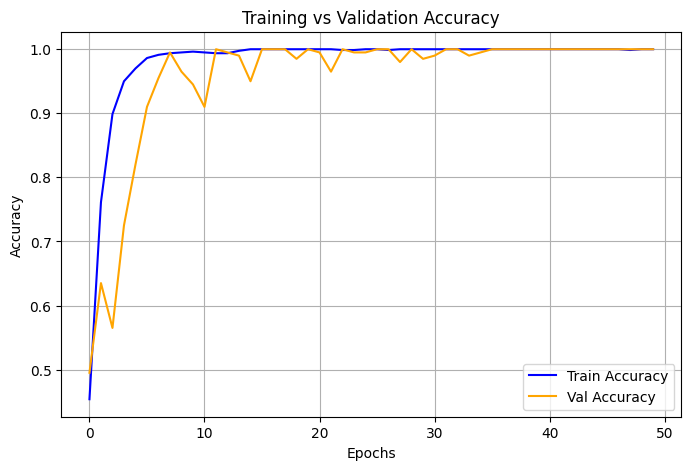

In [61]:
plt.figure(figsize=(8, 5))
plt.plot(history['sparse_categorical_accuracy'], label = "Train Accuracy", color = 'blue')
plt.plot(history['val_sparse_categorical_accuracy'], label = "Val Accuracy", color = 'orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

training vs validation loss

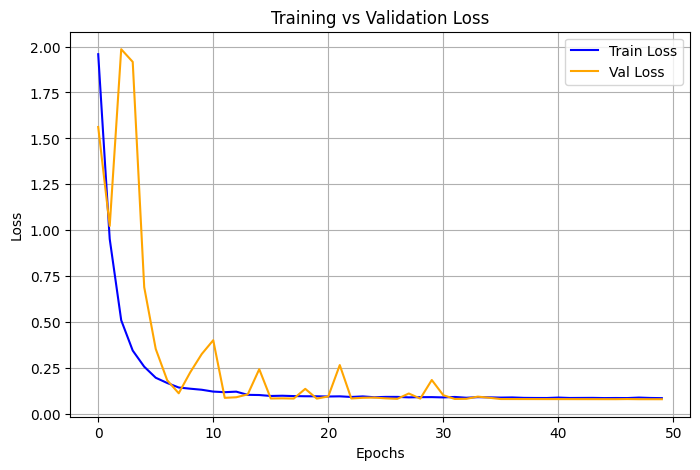

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(history['loss'], label = "Train Loss", color = 'blue')
plt.plot(history['val_loss'], label = "Val Loss", color = 'orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

confusion matrix

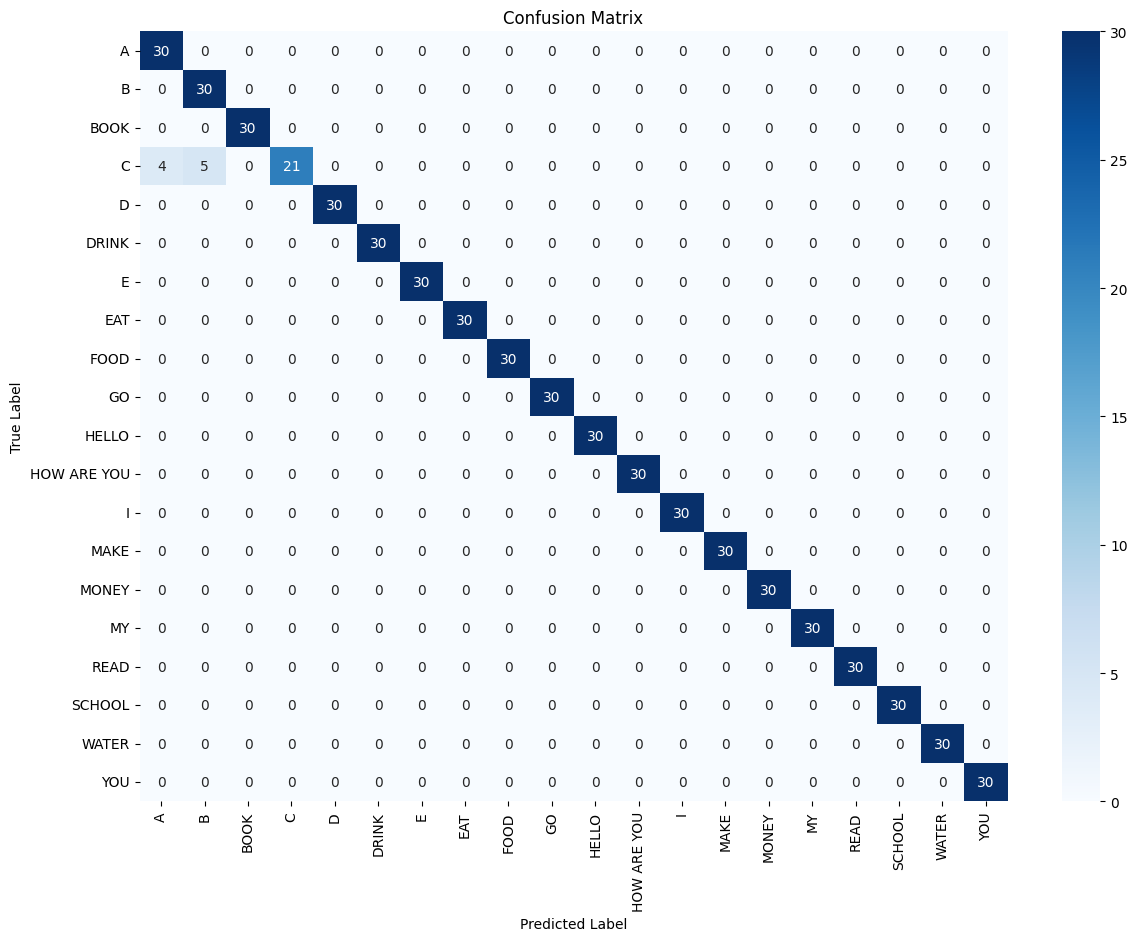

In [63]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize = (14, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

classification report

In [64]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names = class_names))

Classification Report:

              precision    recall  f1-score   support

           A       0.88      1.00      0.94        30
           B       0.86      1.00      0.92        30
        BOOK       1.00      1.00      1.00        30
           C       1.00      0.70      0.82        30
           D       1.00      1.00      1.00        30
       DRINK       1.00      1.00      1.00        30
           E       1.00      1.00      1.00        30
         EAT       1.00      1.00      1.00        30
        FOOD       1.00      1.00      1.00        30
          GO       1.00      1.00      1.00        30
       HELLO       1.00      1.00      1.00        30
 HOW ARE YOU       1.00      1.00      1.00        30
           I       1.00      1.00      1.00        30
        MAKE       1.00      1.00      1.00        30
       MONEY       1.00      1.00      1.00        30
          MY       1.00      1.00      1.00        30
        READ       1.00      1.00      1.00        30
   

learning rate vs validation accuracy

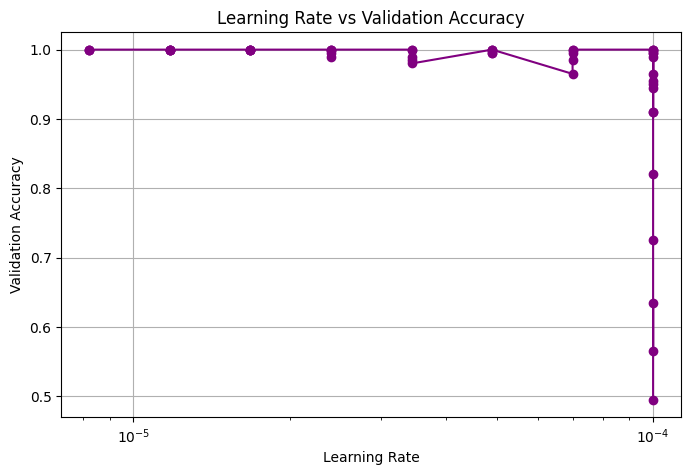

In [65]:
if 'learning_rate' in history:
    plt.figure(figsize = (8, 5))
    plt.plot(history['learning_rate'], history['val_sparse_categorical_accuracy'], marker = 'o', linestyle = '-', color = 'purple')
    plt.xlabel("Learning Rate")
    plt.ylabel("Validation Accuracy")
    plt.xscale('log')  # log scale to better visualize LR changes
    plt.title("Learning Rate vs Validation Accuracy")
    plt.grid()
    plt.show()
else:
    print("Learning rate data is not available in history.")